### 테스트 데이터셋 만들기
훈련하는게 아니므로 train, val은 생략.

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,1,0,0,0,0
1,38,17076.0,40.0,0,NaN,72.0,2.0,0.0,CS-12 E,1985-02-15 11:48:22,...,NaN,NaN,10,records100/00000/00038_lr,records500/00000/00038_hr,1,0,0,0,0
2,40,19501.0,60.0,0,NaN,85.0,2.0,0.0,CS-12 E,1985-02-20 11:43:45,...,NaN,NaN,10,records100/00000/00040_lr,records500/00000/00040_hr,1,0,0,0,0
3,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,1,0,0,0,0
4,59,19475.0,54.0,0,NaN,67.0,2.0,0.0,CS-12 E,1985-06-12 06:36:01,...,NaN,NaN,10,records100/00000/00059_lr,records500/00000/00059_hr,1,0,0,0,0


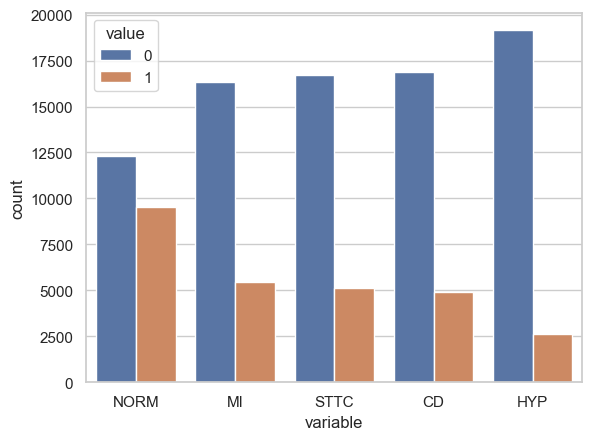

In [1]:
from torch.utils.data import DataLoader
from ver5_journal.common.data.ECG_Data import ECG_Data
from ver5_journal.common.data.create_final_data import create_final_data

final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)
ECG_test.head()

### 최적의 threshold로 테스트

In [8]:
from ver5_journal.common.network.BCResNets import BCResNets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 모델 순서 정의
sequence = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

total = 0
# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'../common/best_models/{dd}_model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    # model.load_state_dict(torch.load(model_path, weights_only=True))
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)
    # 모델의 전체 파라미터 수를 계산
    param = sum(p.numel() for p in model.parameters())
    total += param
    print(f"{dd} parameters: {param}")

# 모델의 전체 파라미터 수를 계산
print(f"total param: {total}")

NORM parameters: 27769
MI parameters: 27769
STTC parameters: 27769
CD parameters: 27769
HYP parameters: 27769
total param: 138845


Classifier NORM - AUC: 0.9422
Optimal threshold for classifier NORM using Youden's J: 0.4685


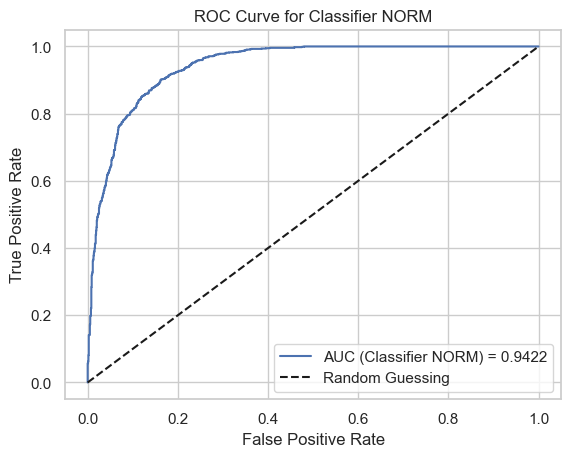

Classifier MI - AUC: 0.9236
Optimal threshold for classifier MI using Youden's J: 0.3026


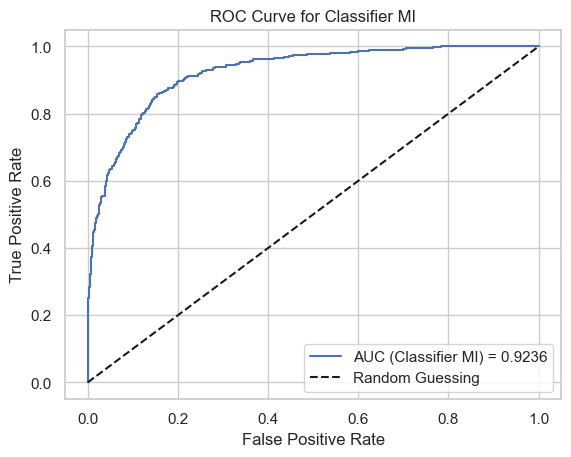

Classifier STTC - AUC: 0.9317
Optimal threshold for classifier STTC using Youden's J: 0.3310


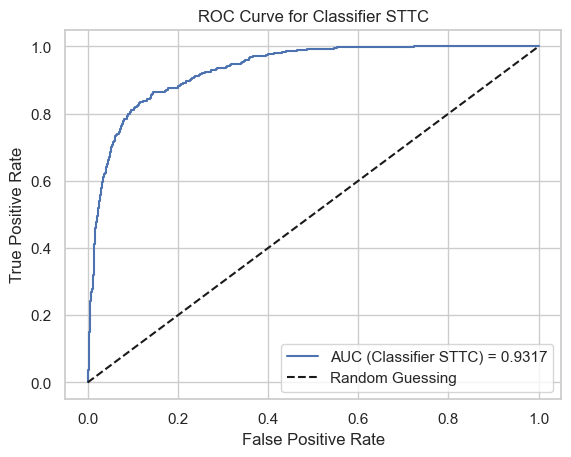

Classifier CD - AUC: 0.9208
Optimal threshold for classifier CD using Youden's J: 0.4901


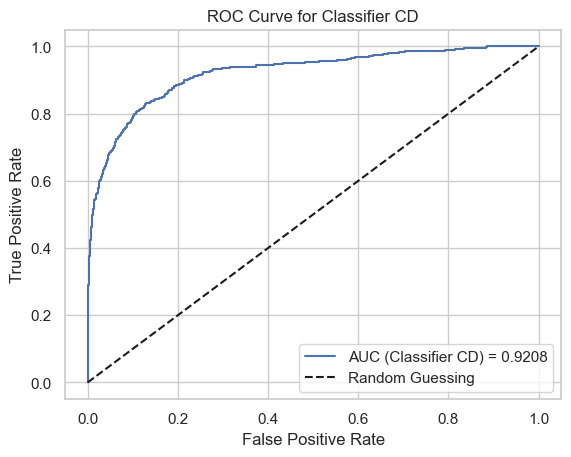

Classifier HYP - AUC: 0.9090
Optimal threshold for classifier HYP using Youden's J: 0.4097


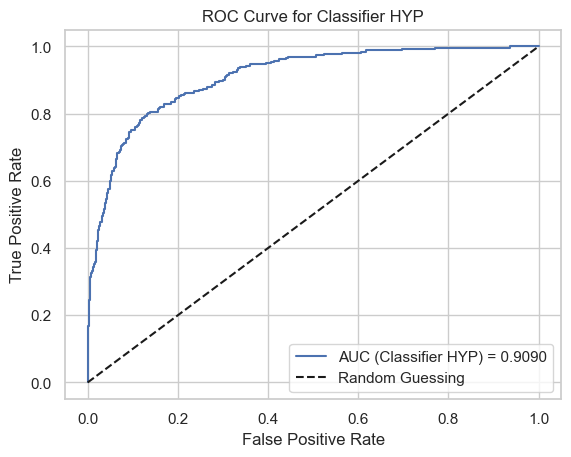

In [5]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

optimal_thresholds = []
auc_values = []

# 각 분류기에서 Youden's J 통계량을 사용해 최적 임계값을 찾는 코드
for idx, model in enumerate(best_models):
    y_true = []
    y_scores = []

    # 테스트 데이터셋에서 예측 결과 저장
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            # 각 배치 내 모든 샘플에 대해 처리
            for i in range(data.size(0)):
                sample = data[i].unsqueeze(0)
                output = model(sample)
                output = torch.sigmoid(output).item()  # 확률 값으로 변환
                y_scores.append(output)  # 스코어 저장
                y_true.append(label[i, idx].item())  # 해당 클래스에 대한 실제값 저장

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Youden's J 통계량 계산 (TPR - FPR)
    youdens_j = tpr - fpr
    
    # Youden's J가 최대인 임계값 찾기
    optimal_idx = np.argmax(youdens_j)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)    
    # AUC도 계산
    auc_value = auc(fpr, tpr)
    auc_values.append(auc_value)

    print(f'Classifier {sequence[idx]} - AUC: {auc_value:.4f}')
    print(f'Optimal threshold for classifier {sequence[idx]} using Youden\'s J: {optimal_threshold:.4f}')
    
    # 추가적으로 ROC 커브 시각화 (필요시 주석 해제)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC (Classifier {sequence[idx]}) = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Classifier {sequence[idx]}')
    plt.legend(loc="lower right")
    plt.show()

### 각 분류기의 개별 지표(classification_report) 및 통합 지표(Hamming Loss) 시각화

In [6]:
import torch
import numpy as np

loss_fn = torch.nn.BCELoss()
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장

# 테스트 데이터셋을 연결된 모델에 사용
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # 각 데이터 포인트별로 모든 클래스에 대한 예측값을 저장하기 위한 리스트
        batch_predictions = []
        batch_loss = 0  # 배치에 대한 Loss 저장

        # 각 분류기에 대해 예측값을 얻음 (모델을 순차적으로 실행)
        for idx, model in enumerate(best_models):
            output = model(data)  # 각 모델이 배치에 대한 예측값을 출력 (배치 크기만큼의 값 반환)
            output = torch.sigmoid(output).squeeze(-1)  # Sigmoid 함수 적용 후 배치 크기 유지

            # 실제 레이블에서 해당 클래스만 선택
            label_data = label[:, idx].float()  # 각 클래스에 대한 실제 레이블  
            loss = loss_fn(output, label_data)  # 각 클래스에 대한 Loss 계산
            batch_loss += loss.item()  # 배치에 대한 Loss 누적

            # 최적 임계값 적용하여 각 모델의 출력이 임계값을 넘으면 1, 아니면 0으로 설정
            predictions = (output.detach().cpu().numpy() > optimal_thresholds[idx]).astype(int)
            batch_predictions.append(predictions)

        # 배치에 대한 평균 Loss 계산
        batch_loss /= len(best_models)  # 각 모델별로 계산된 Loss의 평균
        total_test_loss += batch_loss  # 배치별 Loss를 전체 테스트 Loss에 누적

        # 모든 클래스에 대한 예측값을 저장
        batch_predictions = np.array(batch_predictions)  # (num_models, batch_size) 형태
        batch_predictions = batch_predictions.T  # (batch_size, num_models) 형태로 변환

        # 각 샘플에 대해 예측값과 실제값 저장
        y_true.extend(label.cpu().numpy())  # 실제값 (멀티레이블)
        y_pred.extend(batch_predictions)    # 예측값 (멀티레이블)

In [7]:
from sklearn.metrics import hamming_loss
# 평가 지표 계산
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 각 레이블별 Classification Report 계산
for i, label_name in enumerate(label_columns):
    print(f"\nClassification Report for Label: {label_name}")
    report = classification_report(y_true[:, i], y_pred[:, i], target_names=[f'{label_name}_0', f'{label_name}_1'], zero_division=0)
    print(report)

# 멀티레이블 전체의 통합 지표 계산 (MacroAUC, Hamming Loss)
# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')
hamming = hamming_loss(y_true, y_pred)
print(f'Hamming Loss with optimal thresholds: {hamming:.4f}')


Classification Report for Label: NORM
              precision    recall  f1-score   support

      NORM_0       0.92      0.84      0.87      1235
      NORM_1       0.81      0.90      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.87      0.86      2198
weighted avg       0.87      0.86      0.87      2198


Classification Report for Label: MI
              precision    recall  f1-score   support

        MI_0       0.95      0.84      0.89      1648
        MI_1       0.65      0.86      0.74       550

    accuracy                           0.85      2198
   macro avg       0.80      0.85      0.81      2198
weighted avg       0.87      0.85      0.85      2198


Classification Report for Label: STTC
              precision    recall  f1-score   support

      STTC_0       0.95      0.86      0.90      1692
      STTC_1       0.64      0.86      0.74       506

    accuracy                           0.86      2198
   macro avg 